# Introduction

In this exploratory notebook, we investigate how distances between inputs change as the inputs propagate through a network. This work is inspired by my Bottleneck MLP notebook where I saw that deeper classifier layers had more clustered/separable representations of inputs from the same class. Of course, that was for a toy example with a very simple classifier. We will investigate how distances change across layers of more sophisticated pretrained models.

One other slight connection between previous work and this notebook is that the perceptual threat model leverages activations from different layers to imitate the true human perception. That is, the combination of distances between the represenations of an input and an adversarial example at different layers is used to create a single 'perceptual' metric. 

It seems intuitive that classifiers would learn this self-organizing behavior in feature extraction layers to facilitate easier classification in the final layers. For the heck of it, let's check for ourselves and see if anything surprises us. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data
import torchvision.datasets as datasets
import copy
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19 = models.vgg19_bn(pretrained=True).to(device).eval()

In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

def norm_input(input):
  return (input-mean)/std

First let's try on images of random noise to see how the distances between them change. My hypothesis is that these distances will not change as much as distances for images from the train set. 

In [ ]:
# each VGG block has a conv, batchnorm, and then a ReLU
# let's record the feature map after each ReLU
x = torch.rand((64,3,32,32))
y = torch.rand((64,3,32,32))
def get_feature_maps(cnn, input):
  i = 0
  input = norm_input(input)
  feature_maps = [input]
  for layer in cnn.features.children():
    input = layer(input)
    if isinstance(layer, nn.ReLU):
      feature_maps.append(input)
  return feature_maps
fm1, fm2 = [get_feature_maps(vgg19, input) for input in [x,y]]

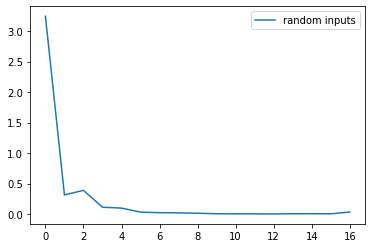

In [ ]:
def display_differences_in_fms(fm1, fm2, label=''):
  metric = nn.MSELoss()
  distances = [metric(fm1[i], fm2[i]).item() for i in range(len(fm1))]
  plt.plot(distances, label=label)
  plt.legend()
  return distances

_ = display_differences_in_fms(fm1, fm2, label='random inputs')

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

Files already downloaded and verified


In [ ]:
print(dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [ ]:
def get_one_class_loader(ind=5, batch_size=128):
  dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
  inds = np.where(np.array(dataset.targets) == ind)[0]
  dataset.data = np.take(dataset.data, inds, axis=0)
  dataset.targets = [ind]*len(inds)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  batch,_ = next(iter(loader))
  return loader

In [ ]:
dog_loader = get_one_class_loader(ind=5)
cat_loader = get_one_class_loader(ind=3)
plane_loader = get_one_class_loader(ind=0)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Now let's inspect data that is closer to the training distribution. My idea is that distances will be warped more aggressively over subsets of the image domain that were involved in training. We should note that these images are far lower resolution than ImageNet (training distr), but similar in content. 
We first see how they differ class to class. 

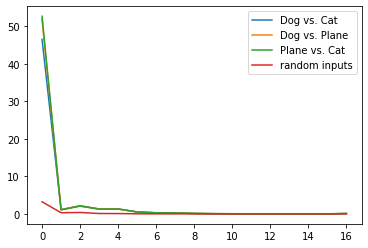

In [ ]:
dog_batch = next(iter(dog_loader))[0]
cat_batch = next(iter(cat_loader))[0]
plane_batch = next(iter(plane_loader))[0]
dog_fm = get_feature_maps(vgg19, dog_batch)
cat_fm = get_feature_maps(vgg19, cat_batch)
plane_fm = get_feature_maps(vgg19, plane_batch)
dog_cat = display_differences_in_fms(dog_fm, cat_fm, label='Dog vs. Cat')
dog_plane = display_differences_in_fms(dog_fm, plane_fm, label='Dog vs. Plane')
plane_cat = display_differences_in_fms(plane_fm, cat_fm, label='Plane vs. Cat')
rand_rand = display_differences_in_fms(fm1, fm2, label='random inputs')

Interestingly, the pattern is similar for all three comparisons. Also, the scale of differences is larger for inputs from trained classes as opposed to random inputs. One curious thing is that the differences trend to zero in the most of the deep layers, except in the final layer where they begin to separate slightly (only for inputs from classes the classsifier was trained on). Let's see how feature maps of inputs from the same class differ to give ourselves a better baseline.

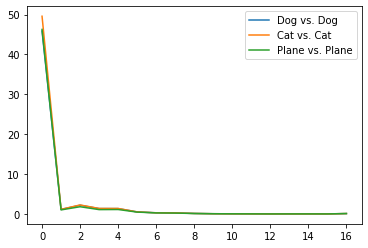

In [ ]:
dog_batch2 = (next(iter(dog_loader)))[0]
cat_batch2 = next(iter(cat_loader))[0]
plane_batch2 = next(iter(plane_loader))[0]
dog_fm2 = get_feature_maps(vgg19, dog_batch2)
cat_fm2 = get_feature_maps(vgg19, cat_batch2)
plane_fm2 = get_feature_maps(vgg19, plane_batch2)
dog_dog = display_differences_in_fms(dog_fm, dog_fm2, label='Dog vs. Dog')
cat_cat = display_differences_in_fms(cat_fm, cat_fm2, label='Cat vs. Cat')
plane_plane = display_differences_in_fms(plane_fm, plane_fm2, label='Plane vs. Plane')

Still very similar to what we saw before. The real test is to see what happens when we normalize cross-class distances to the mean of the intra-class distances, though this does not seem promising.

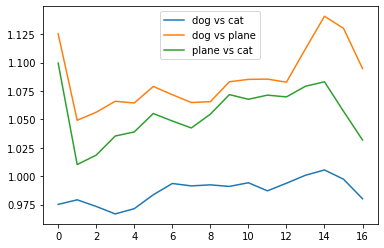

In [ ]:
dog_cat_normed = [2*dog_cat[i]/(dog_dog[i]+cat_cat[i]) for i in range(len(dog_cat))]
dog_plane_normed = [2*dog_plane[i]/(dog_dog[i]+plane_plane[i]) for i in range(len(dog_cat))]
plane_cat_normed = [2*plane_cat[i]/(plane_plane[i]+cat_cat[i]) for i in range(len(dog_cat))]
plt.plot(dog_cat_normed, label='dog vs cat')
plt.plot(dog_plane_normed, label='dog vs plane')
plt.plot(plane_cat_normed, label='plane vs cat')
plt.legend()

So, we do see that the distances between inputs from different classes are indeed further apart (though not by much) on average than inputs from the same class throughout all layers in the VGG network. However, they do not get further separated across the layers. 

What can be the explanation for this? I don't know. Perhaps the feature extraction layers are not concerned with making the data more separable, and this instead only happens in the final fully connected classifying layers. 

For the heck of it, we'll try again with resnet.


EDIT: I tried again with more samples (32 to 128), and the separation became much less pronounced. We do see that separation mostly increases across layers 2 through 14, and then there is a surprisingly uniform sharp decrease in the final couple layers.

In [ ]:
resnet18 = models.resnet18(pretrained=True).eval()
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

So the resnet has a bunch of Sequential modules, each consisting of 'BasicBlock's. Let's get the activations after a bunch of these I know this is super hacky -- I apologize :/. The try-catch at the end there (once again, forgive me) is because we are using CIFAR inputs instead of ImageNet -- we'll just ignore that layer.

In [ ]:
def get_resnet_features(input, resnet=resnet18):
  feature_maps = []
  input = norm_input(input)
  i = 0
  for layer in resnet.children():
    for c in layer.children():
      i = i+1
      input = c(input)
      feature_maps.append(input)
    if i == 0:
      try:
        input = layer(input)
        feature_maps.append(input)
      except Exception as e:
        print('failed at layer: ', layer)
    i=0
  return feature_maps

In [ ]:
dog_resnet_fm = get_resnet_features(dog_batch)
dog_resnet_fm2 = get_resnet_features(dog_batch2)
cat_resnet_fm = get_resnet_features(cat_batch)
cat_resnet_fm2 = get_resnet_features(cat_batch2)
plane_resnet_fm = get_resnet_features(plane_batch)
plane_resnet_fm2 = get_resnet_features(plane_batch2)

failed at layer:  Linear(in_features=512, out_features=1000, bias=True)
failed at layer:  Linear(in_features=512, out_features=1000, bias=True)
failed at layer:  Linear(in_features=512, out_features=1000, bias=True)
failed at layer:  Linear(in_features=512, out_features=1000, bias=True)
failed at layer:  Linear(in_features=512, out_features=1000, bias=True)
failed at layer:  Linear(in_features=512, out_features=1000, bias=True)


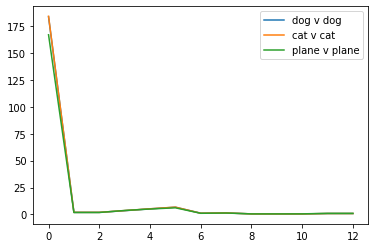

In [ ]:
dog_dog_resnet = display_differences_in_fms(dog_resnet_fm, dog_resnet_fm2, label='dog v dog')
cat_cat_resnet = display_differences_in_fms(cat_resnet_fm, cat_resnet_fm2, label='cat v cat')
plane_plane_resnet = display_differences_in_fms(plane_resnet_fm, plane_resnet_fm2, label='plane v plane')

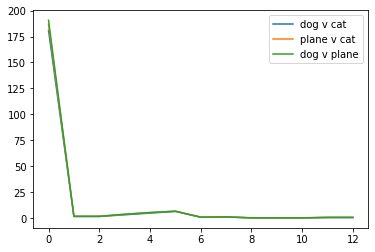

In [ ]:
dog_cat_resnet = display_differences_in_fms(dog_resnet_fm, cat_resnet_fm, label='dog v cat')
plane_cat_resnet = display_differences_in_fms(plane_resnet_fm, cat_resnet_fm2, label='plane v cat')
dog_plane_resnet = display_differences_in_fms(dog_resnet_fm, plane_resnet_fm2, label='dog v plane')

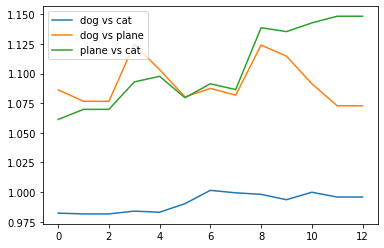

In [ ]:
dog_cat_normed_resnet = [2*dog_cat_resnet[i]/(dog_dog_resnet[i]+cat_cat_resnet[i]) for i in range(len(dog_cat_resnet))]
dog_plane_normed_resnet = [2*dog_plane_resnet[i]/(dog_dog_resnet[i]+plane_plane_resnet[i]) for i in range(len(dog_cat_resnet))]
plane_cat_normed_resnet = [2*plane_cat_resnet[i]/(plane_plane_resnet[i]+cat_cat_resnet[i]) for i in range(len(dog_cat_resnet))]
plt.plot(dog_cat_normed_resnet, label='dog vs cat')
plt.plot(dog_plane_normed_resnet, label='dog vs plane')
plt.plot(plane_cat_normed_resnet, label='plane vs cat')
plt.legend()

This is much more difficult to interpret. 

If I had faith in this idea, what I would do next is actually train a CIFAR10 classifier and use that to do the above analyses. But, I don't have much faith in this idea so I'm going to move on to something else. 

If you're wondering, why didn't I train a classifier from the get go? The answer is that the perceptual metric is model agnostic -- in theory, you could use feature maps extracted from hidden layers of any kind of model. 